In [1]:
!pip install understatapi pandas --quiet

In [2]:
import pandas as pd
import understatapi
import matplotlib.pyplot as plt
import numpy as np

client = understatapi.UnderstatClient()

In [19]:

def to_df(obj):
    # Handle common shapes from APIs
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, list):
        if not obj:
            return pd.DataFrame()
        if isinstance(obj[0], pd.DataFrame):
            return pd.concat(obj, ignore_index=True)
        if isinstance(obj[0], dict):
            return pd.json_normalize(obj)  # list of dicts
        # fallback: make a 1-col frame
        return pd.DataFrame({"value": obj})
    if isinstance(obj, dict):
        # try typical row containers
        for key in ("data", "matches", "fixtures", "results", "items"):
            if key in obj:
                return to_df(obj[key])
        return pd.json_normalize(obj)
    # last resort
    return pd.DataFrame(obj)

seasons = [str(y) for y in range(2014, 2024)]
frames = []

for s in seasons:
    raw = client.league(league="EPL").get_match_data(season=s)
    df = to_df(raw)
    if df is None or df.empty:
        continue
    df["season"] = s
    frames.append(df)

league_data = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

print(league_data.columns)

Index(['id', 'isResult', 'datetime', 'h.id', 'h.title', 'h.short_title',
       'a.id', 'a.title', 'a.short_title', 'goals.h', 'goals.a', 'xG.h',
       'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'season'],
      dtype='object')


In [21]:
print(league_data.columns.tolist())  # all column names      # if datetime is index

['id', 'isResult', 'datetime', 'h.id', 'h.title', 'h.short_title', 'a.id', 'a.title', 'a.short_title', 'goals.h', 'goals.a', 'xG.h', 'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'season']


In [23]:
league_data = league_data.rename(columns = {'h.title':'Home', 'h.short_title':'Home Abbreviation', 'a.title':'Away',
'a.short_title':'Away Abbreviation', 'goals.h':'Home Goals', 'goals.a':'Away Goals', 'xG.h':'Home xG', 'xG.a': 'Away xG'})
shown_col = ['datetime','id', 'Home', 'Home Abbreviation', 'Home xG', 'Home Goals', 'Away Goals','Away xG', 'Away Abbreviation', 'Away']
league_data = league_data[shown_col]
league_data['Prediction'] = (
    ((league_data['Home xG'] > league_data['Away xG']) & (league_data['Home Goals'] > league_data['Away Goals'])) |
    ((league_data['Away xG'] > league_data['Home xG']) & (league_data['Away Goals'] > league_data['Home Goals']))
)

league_data.head(20)

,datetime,id,Home,Home Abbreviation,Home xG,Home Goals,Away Goals,Away xG,Away Abbreviation,Away,Prediction
0,2014-08-16 12:45:00,4749,Manchester United,MUN,1.16635,1,2,0.278076,SWA,Swansea,False
1,2014-08-16 15:00:00,4750,Leicester,LEI,1.2783,2,2,0.613273,EVE,Everton,False
2,2014-08-16 15:00:00,4751,Queens Park Rangers,QPR,1.90067,0,1,1.11757,HUL,Hull,False
3,2014-08-16 15:00:00,4752,Stoke,STO,0.423368,0,1,0.909774,AVL,Aston Villa,True
4,2014-08-16 15:00:00,4753,West Bromwich Albion,WBA,1.68343,2,2,0.991901,SUN,Sunderland,False
5,2014-08-16 15:00:00,4754,West Ham,WHU,1.8531,0,1,1.01706,TOT,Tottenham,False
6,2014-08-16 17:30:00,4755,Arsenal,ARS,1.55411,2,1,0.158151,CRY,Crystal Palace,True
7,2014-08-17 13:30:00,4756,Liverpool,LIV,1.33192,2,1,1.55248,SOU,Southampton,False
8,2014-08-17 16:00:00,4757,Newcastle United,NEW,0.965583,0,2,1.48053,MCI,Manchester City,True
9,2014-08-18 20:00:00,4758,Burnley,BUR,0.371141,1,3,2.12996,CHE,Chelsea,True


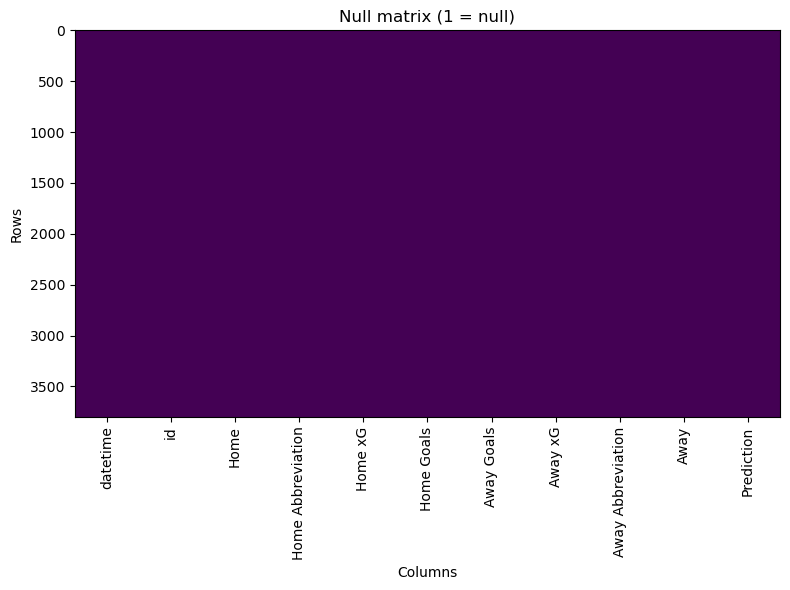

In [24]:
mask = league_data.isna().values.astype(int)  # 1 = null, 0 = not null
plt.figure(figsize=(8, 6))
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.title('Null matrix (1 = null)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(range(league_data.shape[1]), league_data.columns, rotation=90)
plt.tight_layout()
plt.show()


In [25]:
row_null_hist = (league_data.isna().sum(axis=1)
                   .value_counts()
                   .sort_index()
                   .rename_axis('nulls_per_row')
                   .to_frame('num_rows'))
row_null_hist.head(5)

,num_rows
nulls_per_row,
0,3800


In [26]:
shot_data = client.match(match='28778').get_shot_data()
shot_data

{'h': [{'id': '637500',
   'minute': '2',
   'result': 'SavedShot',
   'X': '0.7619999694824219',
   'Y': '0.6990000152587891',
   'xG': '0.014601008035242558',
   'player': 'Hugo Ekitike',
   'h_a': 'h',
   'player_id': '8995',
   'situation': 'OpenPlay',
   'season': '2025',
   'shotType': 'RightFoot',
   'match_id': '28778',
   'h_team': 'Liverpool',
   'a_team': 'Bournemouth',
   'h_goals': '4',
   'a_goals': '2',
   'date': '2025-08-15 19:00:00',
   'player_assisted': 'Cody Gakpo',
   'lastAction': 'Pass'},
  {'id': '637501',
   'minute': '3',
   'result': 'SavedShot',
   'X': '0.855999984741211',
   'Y': '0.3129999923706055',
   'xG': '0.04265604913234711',
   'player': 'Mohamed Salah',
   'h_a': 'h',
   'player_id': '1250',
   'situation': 'OpenPlay',
   'season': '2025',
   'shotType': 'LeftFoot',
   'match_id': '28778',
   'h_team': 'Liverpool',
   'a_team': 'Bournemouth',
   'h_goals': '4',
   'a_goals': '2',
   'date': '2025-08-15 19:00:00',
   'player_assisted': 'Hugo Ekiti